In [1]:
from ipynb.fs.full.preprocessing_text import PreprocessTweet
from ipynb.fs.full.dict_lexicons import read_lexicon
from ipynb.fs.full.lexicon_mapping import LexiconMapper, Analyzer
from ipynb.fs.full.bert_helper import create_raw_input, pull_bert, get_max_lengths, bert_encode
import pandas as pd

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [2]:
vad_lexicon = read_lexicon('NRC-VAD')
df = pd.read_csv("D:\\Marko\\MoviesSentimentAnalysis\\140SentimentDataset\\training.1600000.processed.noemoticon.csv", 
           names = [
                    'target',
                    'id',
                    'date',
                    'flag',
                    'user',
                    'text'
                ])
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
xy_df = pd.DataFrame(df.values[:,0:6:5], columns=['label', 'text'])
xy_df.head()

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [4]:
preprocessor = PreprocessTweet()
preprocessed_df = preprocessor.preprocess_tweets(xy_df, False, True)
preprocessed_df.head()

,Label,Tweet,Mark,Caps,Letters
0,0,awww thats a bummer you shoulda got david carr...,False,False,True
1,0,is upset that he cant update his facebook by t...,True,False,True
2,0,i dived many times for the ball managed to sav...,False,True,False
3,0,my whole body feels itchy and like its on fire,False,False,False
4,0,no its not behaving at all im mad why am i her...,False,True,False


In [5]:
preprocessed_stopwords = preprocessor.preprocess_tweets(xy_df, False, False)
df_stopwords = preprocessor.remove_stopwords(\
                                             pd.DataFrame(preprocessed_stopwords.values, \
                                             columns = ['label', 'text', 'mark', 'caps', 'letters']))
df_stopwords.head()

,label,text,mark,caps,letters,stopwordsx
0,0,awww that s a bummer you shoulda got david car...,False,False,True,awww bummer shoulda got david carr third day
1,0,is upset that he can t update his facebook by ...,True,False,True,upset update facebook texting might cry result...
2,0,i dived many times for the ball managed to sav...,False,True,False,dived many times ball managed save rest go bounds
3,0,my whole body feels itchy and like its on fire,False,False,False,whole body feels itchy like fire
4,0,no it s not behaving at all i m mad why am i h...,False,True,False,behaving mad see


In [6]:
df_stopwords.stopwordsx = preprocessor.lemmatize(df_stopwords.stopwordsx)
df_stopwords.head()

,label,text,mark,caps,letters,stopwordsx
0,0,awww that s a bummer you shoulda got david car...,False,False,True,awww bummer shoulda get david carr third day
1,0,is upset that he can t update his facebook by ...,True,False,True,upset update facebook texting might cry result...
2,0,i dived many times for the ball managed to sav...,False,True,False,dive many time ball manage save rest go bound
3,0,my whole body feels itchy and like its on fire,False,False,False,whole body feel itchy like fire
4,0,no it s not behaving at all i m mad why am i h...,False,True,False,behave mad see


In [7]:
mapper = LexiconMapper()
mapped_tweets = mapper.map_tweets(pd.DataFrame(df_stopwords.values[:,5], columns=['text']), vad_lexicon, 1, True)
mapped_tweets['original'] = preprocessed_df.values[:,1]
mapped_tweets['mark'] = preprocessed_df.values[:,2]
mapped_tweets['caps'] = preprocessed_df.values[:,3]
mapped_tweets['letters'] = preprocessed_df.values[:,4]

In [8]:
mapped_tweets.head()

,text,mapped,original,mark,caps,letters
0,awww bummer shoulda get david carr third day,"[-1, 0.5, -1, 0.594, -1, 0.54, 0.187, 0.269]",awww thats a bummer you shoulda got david carr...,False,False,True
1,upset update facebook texting might cry result...,"[0.68, 0.535, -1, -1, -1, 0.627, 0.49, 0.423, ...",is upset that he cant update his facebook by t...,True,False,True
2,dive many time ball manage save rest go bound,"[0.531, -1, 0.288, 0.427, 0.53, 0.439, 0.167, ...",i dived many times for the ball managed to sav...,False,True,False
3,whole body feel itchy like fire,"[0.357, 0.461, 0.602, 0.726, 0.353, 0.804]",my whole body feels itchy and like its on fire,False,False,False
4,behave mad see,"[0.363, 0.873, 0.269]",no its not behaving at all im mad why am i her...,False,True,False


In [9]:
filtered_nulls = pd.DataFrame([i for i in mapped_tweets.values if len(i[1]) > 0], columns=['text','mapped', 'original', 'mark', 'caps', 'letters'])
print(len(filtered_nulls))
print(len(mapped_tweets))
filtered_nulls = mapper.filter_tweets(filtered_nulls, -1, 0.35)
filtered_nulls.head()
import copy
filtered = copy.deepcopy(filtered_nulls[filtered_nulls.filtered == True])
maximums = mapper.get_maximum(filtered.mapped)
averages = mapper.get_average(filtered.mapped)

1590017
1600000


In [10]:
print(maximums[:10])
print(averages[:10])
filtered['maximums'] = maximums
filtered['averages'] = averages
filtered.head()

[0.667, 0.804, 0.873, 0.598, 0.574, 0.796, 0.531, 0.809, 0.596, 0.773]
[0.44, 0.55, 0.5, 0.48, 0.5, 0.39, 0.36, 0.54, 0.52, 0.55]


,text,mapped,original,mark,caps,letters,filtered,maximums,averages
2,dive many time ball manage save rest go bound,"[0.531, -1, 0.288, 0.427, 0.53, 0.439, 0.167, ...",i dived many times for the ball managed to sav...,False,True,False,True,0.667,0.44
3,whole body feel itchy like fire,"[0.357, 0.461, 0.602, 0.726, 0.353, 0.804]",my whole body feels itchy and like its on fire,False,False,False,True,0.804,0.55
4,behave mad see,"[0.363, 0.873, 0.269]",no its not behaving at all im mad why am i her...,False,True,False,True,0.873,0.50
5,whole crew,"[0.357, 0.598]",not the whole crew,False,False,False,True,0.598,0.48
6,need hug,"[0.574, 0.427]",need a hug,False,False,False,True,0.574,0.50


In [48]:
from collections import Counter
variances = []
for i in filtered.values:
    if len(i[1]) < 3:
        variances.append(0)
        continue
    variance = 0
    elms = 0
    for j in i[1]:
        if j != -1:
            variance = variance + (abs((j - i[8])) * abs((j - i[8])))
            elms = elms + 1
    variances.append(round(variance/(elms-1),2))
print(Counter(variances))
filtered['variance'] = variances
filtered.head()

Counter({0.02: 209235, 0.01: 198844, 0: 182634, 0.03: 160925, 0.04: 110358, 0.05: 68389, 0.06: 40510, 0.07: 22237, 0.08: 13274, 0.09: 7512, 0.1: 4479, 0.11: 2890, 0.12: 1940, 0.13: 1275, 0.14: 848, 0.15: 577, 0.16: 488, 0.17: 322, 0.18: 200, 0.19: 176, 0.2: 122, 0.21: 100, 0.23: 65, 0.22: 64, 0.25: 46, 0.24: 38, 0.26: 34, 0.27: 22, 0.28: 19, 0.29: 12, 0.3: 11, 0.32: 8, 0.31: 8, 0.35: 6, 0.34: 3, 0.33: 3, 0.37: 3, 0.38: 1, 0.36: 1})


,text,mapped,original,mark,caps,letters,filtered,maximums,averages,variance,avg_labels,max_labels
2,dive many time ball manage save rest go bound,"[0.531, -1, 0.288, 0.427, 0.53, 0.439, 0.167, ...",i dived many times for the ball managed to sav...,False,True,False,True,0.667,0.44,0.02,medium,medium
3,whole body feel itchy like fire,"[0.357, 0.461, 0.602, 0.726, 0.353, 0.804]",my whole body feels itchy and like its on fire,False,False,False,True,0.804,0.55,0.04,medium,medium
4,behave mad see,"[0.363, 0.873, 0.269]",no its not behaving at all im mad why am i her...,False,True,False,True,0.873,0.50,0.11,medium,medium
5,whole crew,"[0.357, 0.598]",not the whole crew,False,False,False,True,0.598,0.48,0.00,medium,medium
6,need hug,"[0.574, 0.427]",need a hug,False,False,False,True,0.574,0.50,0.00,medium,medium


In [49]:
analyzer = Analyzer()
analyze_avg = analyzer.labels_distribution(averages, 0.33, 0.68)
analyze_max = analyzer.labels_distribution(maximums, 0.42, 0.88)

print(analyze_max)
print(analyze_avg)

min_sample_max = min(analyze_max)
min_sample_avg = min(analyze_avg)

(70652, 954589, 73090)
(57090, 1009422, 18257)


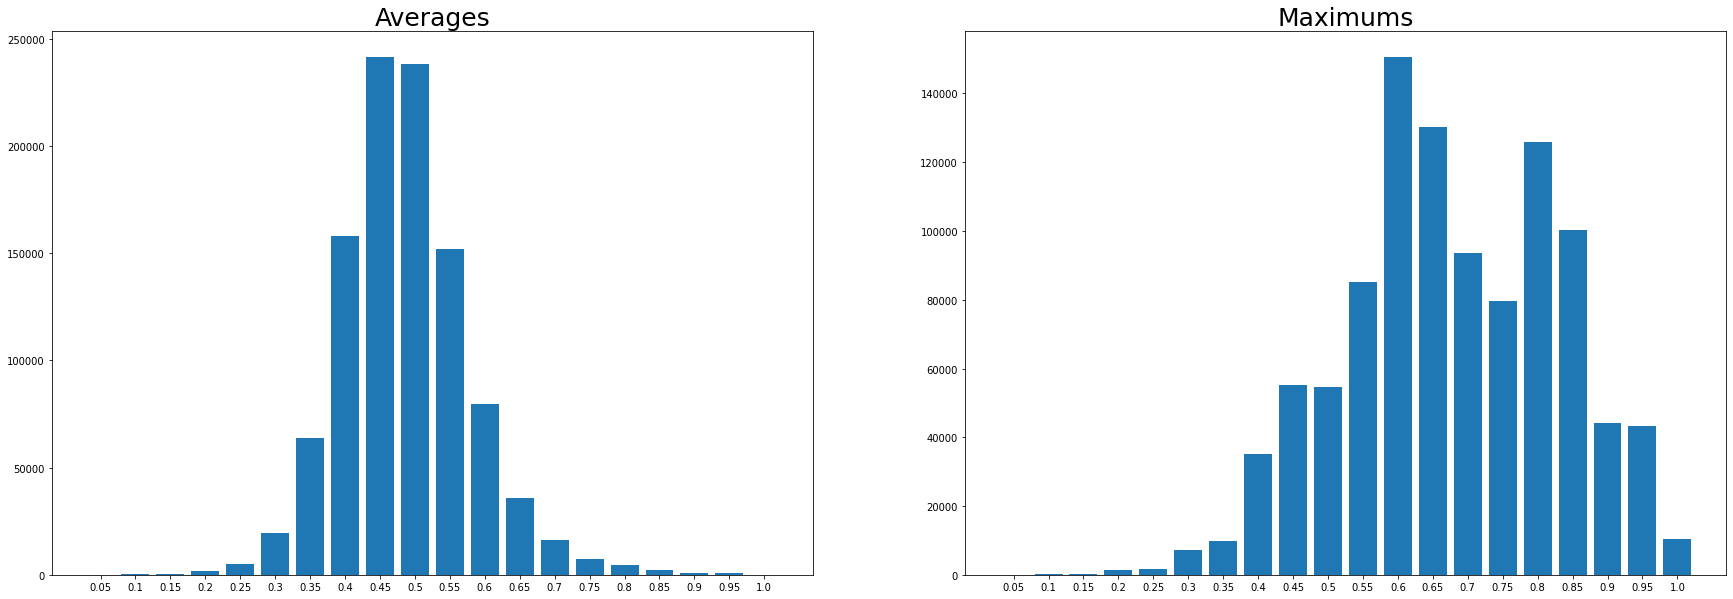

In [146]:
from collections import Counter
import matplotlib.pyplot as plt

def visualize(aggregate):
    d_a = {"0.05": 0, "0.1": 0, "0.15": 0, "0.2": 0, "0.25": 0, "0.3": 0, "0.35":0, "0.4": 0, "0.45": 0,  "0.5":0, "0.55":0, "0.6": 0, "0.65":0, "0.7": 0,"0.75":0, "0.8": 0,"0.85":0, "0.9": 0,"0.95":0, "1.0":0}
    for j in aggregate:
        if j > 0 and j < 0.05:
            d_a["0.05"] = d_a["0.05"] + 1
        elif j >= 0.05 and j < 0.1:
            d_a["0.1"] = d_a["0.1"] + 1
        elif j >= 0.1 and j < 0.15:
            d_a["0.15"] = d_a["0.15"] + 1
        elif j >= 0.15 and j < 0.2:
            d_a["0.2"] = d_a["0.2"] + 1
        elif j >= 0.2 and j < 0.25:
            d_a["0.25"] = d_a["0.25"] + 1
        elif j >= 0.25 and j < 0.3:
            d_a["0.3"] = d_a["0.3"] + 1
        elif j >= 0.3 and j < 0.35:
            d_a["0.35"] = d_a["0.35"] + 1
        elif j >= 0.35 and j < 0.4:
            d_a["0.4"] = d_a["0.4"] + 1
        elif j >= 0.4 and j < 0.45:
            d_a["0.45"] = d_a["0.45"] + 1
        elif j >= 0.45 and j < 0.5:
            d_a["0.5"] = d_a["0.5"] + 1
        elif j >= 0.5 and j < 0.55:
            d_a["0.55"] = d_a["0.55"] + 1
        elif j >= 0.55 and j < 0.6:
            d_a["0.6"] = d_a["0.6"] + 1
        elif j >= 0.6 and j < 0.65:
            d_a["0.65"] = d_a["0.65"] + 1
        elif j >= 0.6 and j < 0.7:
            d_a["0.7"] = d_a["0.7"] + 1
        elif j >= 0.7 and j < 0.75:
            d_a["0.75"] = d_a["0.75"] + 1
        elif j >= 0.75 and j < 0.8:
            d_a["0.8"] = d_a["0.8"] + 1
        elif j >= 0.8 and j < 0.85:
            d_a["0.85"] = d_a["0.85"] + 1
        elif j >= 0.8 and j < 0.9:
            d_a["0.9"] = d_a["0.9"] + 1
        elif j >= 0.9 and j < 0.95:
            d_a["0.95"] = d_a["0.95"] + 1
        else:
            d_a["1.0"] = d_a["1.0"] + 1
    return d_a
data = [visualize(averages), visualize(maximums)]
titles = ['Averages', 'Maximums']
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(30,10))
for i, ax, title in zip(data, axes, titles):
    ax.set_title(title, size=25)
    ax.bar([k for k in i.keys()], i.values())
plt.show()

In [51]:
lens = analyzer.get_length_statistics(filtered)

<BarContainer object of 27 artists>

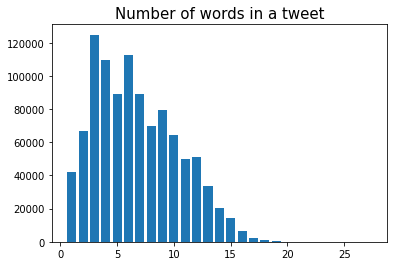

In [52]:
import matplotlib.pyplot as plt

plt.title("Number of words in a tweet", size=15)
plt.bar([k for k in lens.keys()], lens.values())

In [280]:
minimums = [min([j for j in i if j > -1]) for i in filtered.mapped]

In [470]:
def add_labels(tweets, index, low_bound, mlower_bound, mupper_bound, high_bound):
    classes = []
    for i in tweets.values[:,index]:
        if i >= high_bound:
            classes.append("high")
        elif i <= low_bound and i > 0:
            classes.append("low")
        elif i > mlower_bound and i < mupper_bound:
            classes.append("medium")
        else:
            classes.append("none")
        
    tweets['values'] = classes
        
    return tweets

filtered = add_labels(filtered, 8, 0.3, 0.4, 0.5, 0.7)
filtered.head()
filtered.columns=['text', 'mapped', 'original', 'mark', 'caps', 'letters', 'filtered', 'maximums', 'averages', 'variance', 'avg_labels']
filtered = add_labels(filtered, 7, 0.4, 0.5, 0.6, 0.8)
filtered.columns=['text', 'mapped', 'original', 'mark', 'caps', 'letters', 'filtered', 'maximums', 'averages', 'variance', 'avg_labels', 'max_labels']
filtered['minimums'] = minimums
filtered.head()
#filtered = filtered.drop(['avg_labels', 'max_labels', 'minimums'], axis = 1)

,text,mapped,original,mark,caps,letters,filtered,maximums,averages,variance,avg_labels,max_labels,minimums
2,dive many time ball manage save rest go bound,"[0.531, -1, 0.288, 0.427, 0.53, 0.439, 0.167, ...",i dived many times for the ball managed to sav...,False,True,False,True,0.667,0.44,0.02,medium,none,0.167
3,whole body feel itchy like fire,"[0.357, 0.461, 0.602, 0.726, 0.353, 0.804]",my whole body feels itchy and like its on fire,False,False,False,True,0.804,0.55,0.04,none,high,0.353
4,behave mad see,"[0.363, 0.873, 0.269]",no its not behaving at all im mad why am i her...,False,True,False,True,0.873,0.50,0.11,none,high,0.269
5,whole crew,"[0.357, 0.598]",not the whole crew,False,False,False,True,0.598,0.48,0.00,medium,medium,0.357
6,need hug,"[0.574, 0.427]",need a hug,False,False,False,True,0.574,0.50,0.00,none,medium,0.427


<ipython-input-484-91416567776d>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_filtered = filtered[filtered.variance < 0.07][filtered.variance > 0]


5171


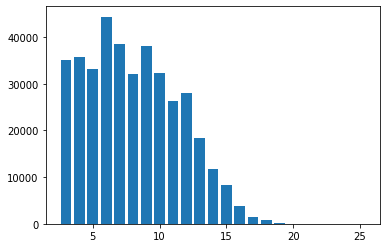

In [484]:
new_filtered = filtered[filtered.variance < 0.07][filtered.variance > 0]
new_filtered = new_filtered[new_filtered.avg_labels != 'none']
new_filtered.head()
print(len(new_filtered[new_filtered.avg_labels == "high"]))
filtered_new_lens = analyzer.get_length_statistics(new_filtered)

plt.bar([k for k in filtered_new_lens.keys()], filtered_new_lens.values())
plt.show()

In [497]:
def get_even_distribution(df, attr, min_sample_size):
    
    df_high = df[df.avg_labels == 'high']
    df_med = df[df.avg_labels == 'medium'][df.maximums < 0.65][df.minimums > 0.35]
    df_low = df[df.avg_labels == 'low'][df.maximums < 0.37]
    low_df = mapper.get_sample(df_low, df_low[attr], "low", min_sample_size)
    med_df = mapper.get_sample(df_med, df_med[attr], "medium", min_sample_size)
    high_df = mapper.get_sample(df_high, df_high[attr], "high", min_sample_size)
    
    distr_df = pd.concat([low_df, med_df, high_df])
    return distr_df

avg_df = get_even_distribution(new_filtered, 'avg_labels', 5100)
max_df = get_even_distribution(new_filtered, 'max_labels', 4000)
print(max_df.shape)
print(avg_df.shape)
#max_df.head()

<ipython-input-497-22c2fc2d3afe>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_med = df[df.avg_labels == 'medium'][df.maximums < 0.65][df.minimums > 0.35]
<ipython-input-497-22c2fc2d3afe>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_med = df[df.avg_labels == 'medium'][df.maximums < 0.65][df.minimums > 0.35]
<ipython-input-497-22c2fc2d3afe>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_low = df[df.avg_labels == 'low'][df.maximums < 0.37]
<ipython-input-497-22c2fc2d3afe>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_med = df[df.avg_labels == 'medium'][df.maximums < 0.65][df.minimums > 0.35]
<ipython-input-497-22c2fc2d3afe>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_med = df[df.avg_labels == 'medium'][df.maximums < 0.65][df.minimums > 0.35]


(12000, 13)
(15300, 13)


<ipython-input-497-22c2fc2d3afe>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_low = df[df.avg_labels == 'low'][df.maximums < 0.37]


In [490]:
avg_df[avg_df.avg_labels == "medium"]

,text,mapped,original,mark,caps,letters,filtered,maximums,averages,variance,avg_labels,max_labels,minimums
1253330,sing smokey twitter background,"[0.606, 0.462, -1, 0.357]",sing it smokey well do twitter background,True,True,False,True,0.606,0.48,0.02,medium,none,0.357
5910,back work go,"[0.353, 0.596, 0.441]",back to work i go,True,True,False,True,0.596,0.46,0.02,medium,medium,0.353
693655,hang son tomorrow,"[0.529, 0.365, 0.377]",hanging out with my son tomorrow,False,False,True,True,0.529,0.42,0.01,medium,medium,0.365
28791,thanks plan despite rain,"[0.472, 0.54, -1, 0.388]",thanks we plan to despite the rain,True,False,False,True,0.540,0.47,0.01,medium,medium,0.388
256040,work tomorrow thank gawd good guvment job need...,"[0.596, 0.377, 0.353, -1, 0.368, -1, 0.541, 0....",work tomorrow thank gawd for my good guvment j...,False,True,True,True,0.596,0.48,0.01,medium,medium,0.353
...,...,...,...,...,...,...,...,...,...,...,...,...,...
508873,still shop night baking,"[-1, 0.632, 0.396, 0.455]",still havent been shopping ill be up all night...,False,False,False,True,0.632,0.49,0.02,medium,none,0.396
886226,vote good luck,"[0.5, 0.368, 0.49]",voted good luck,True,False,False,True,0.500,0.45,0.01,medium,none,0.368
580746,sick traffic downtown,"[0.431, 0.559, -1]",so sick of the traffic in downtown,False,False,False,True,0.559,0.49,0.01,medium,medium,0.431
1481877,shippment fail arrive,"[0.44, 0.578, 0.406]",your shippment of fail has arrived,False,True,False,True,0.578,0.47,0.01,medium,medium,0.406


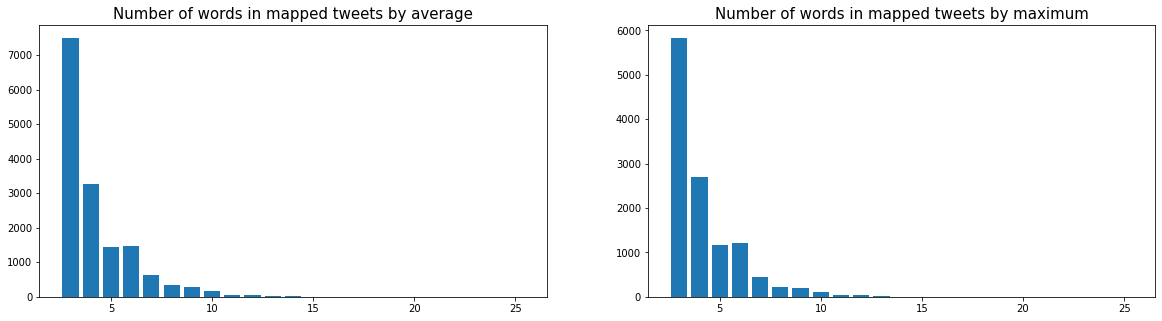

In [498]:
avg_lens = analyzer.get_length_statistics(avg_df)
max_lens = analyzer.get_length_statistics(max_df)

data = [avg_lens, max_lens]
titles = ["Number of words in mapped tweets by average", "Number of words in mapped tweets by maximum", ]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
for rec, ax, title in zip(data, axes, titles):
    ax.set_title(title, size=15)
    ax.bar([k for k in rec.keys()], rec.values())

In [492]:
def init_transfered_model(df, attr, max_seq_len):
    x_train, x_test, y_train, y_test = create_raw_input(df['original'], df[attr], 0.2)
    bert_layer, tokenizer = pull_bert('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/2')
    #max_seq_len = get_max_lengths(df['original'], tokenizer)
    
    X_train = bert_encode(x_train, tokenizer, max_seq_len)
    X_test = bert_encode(x_test, tokenizer, max_seq_len)
    
    return X_train, X_test, y_train, y_test, bert_layer

avgX_train, avgX_test, avgy_train, avgy_test, avgbert_layer = init_transfered_model(avg_df, 'avg_labels', 150)
#maxX_train, maxX_test, maxy_train, maxy_test, maxbert_layer = init_transfered_model(max_df, 'max_labels', 150)

In [493]:
import tensorflow as tf

def create_model(bert_layer, max_seq_len, num_class):

    input_word_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_type_ids")

    bert_input = {
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    }

    outputs = bert_layer(bert_input)
    #print(outputs)
    pooled_output = outputs['pooled_output']
    sequence_output = outputs['sequence_output']

    print(pooled_output)

    output = tf.keras.layers.Dropout(rate=0.05)(sequence_output)
    output = tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu')(output)
    output = tf.keras.layers.AvgPool1D(pool_size=4)(output)
    output = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu')(output)
    output = tf.keras.layers.AvgPool1D(pool_size=2)(output)
    output = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(output)
    output = tf.keras.layers.Conv1D(filters=8, kernel_size=3, activation='relu')(output)
    output = tf.keras.layers.Flatten()(output)
    output = tf.keras.layers.Dense(num_class, activation='softmax')(output)

    model = tf.keras.Model(
        inputs={
            'input_word_ids': input_word_ids,
            'input_mask': input_mask,
            'input_type_ids': input_type_ids
        },
        outputs=output
    )

    model.summary()

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics='accuracy'
    )
    
    return model

model_avg = create_model(avgbert_layer, 150, len(avgy_train[0]))
#model_max = create_model(maxbert_layer, maxmax_seq_len, len(maxy_train[0]))

KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='keras_layer_16/StatefulPartitionedCall:5', description="created by layer 'keras_layer_16'")
Model: "model_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
keras_laye

In [494]:
history_avg = model_avg.fit(
    avgX_train,
    avgy_train,
    epochs=5,
    verbose=1
)

Epoch 1/5
383/383 [==============================] - 507s 1s/step - loss: 0.5576 - accuracy: 0.7575
Epoch 2/5
383/383 [==============================] - 489s 1s/step - loss: 0.3977 - accuracy: 0.8413
Epoch 3/5
383/383 [==============================] - 490s 1s/step - loss: 0.3174 - accuracy: 0.8724
Epoch 4/5
383/383 [==============================] - 488s 1s/step - loss: 0.2678 - accuracy: 0.8977
Epoch 5/5
383/383 [==============================] - 472s 1s/step - loss: 0.2183 - accuracy: 0.9171


In [495]:
model_avg.evaluate(avgX_test, avgy_test)

96/96 [==============================] - 117s 1s/step - loss: 0.3632 - accuracy: 0.8578


[0.3631669282913208, 0.8578431606292725]

In [496]:
model_avg.save('D:/model_85_acc/avg_model')

INFO:tensorflow:Assets written to: D:/model_85_acc/avg_model\assets


INFO:tensorflow:Assets written to: D:/model_85_acc/avg_model\assets


In [500]:
maxX_train, maxX_test, maxy_train, maxy_test, maxbert_layer = init_transfered_model(max_df, 'max_labels', 150)

In [501]:
model_max = create_model(maxbert_layer, 150, len(maxy_train[0]))
history_max = model_max.fit(
    maxX_train,
    maxy_train,
    epochs=4,
    verbose=1
)

KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='keras_layer_17/StatefulPartitionedCall:5', description="created by layer 'keras_layer_17'")
Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
keras_laye

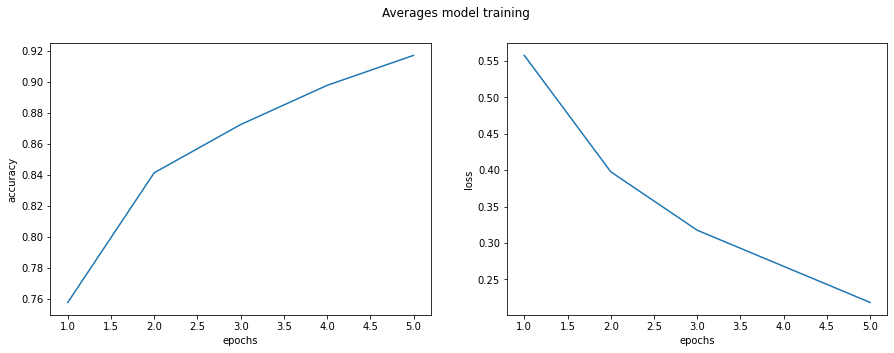

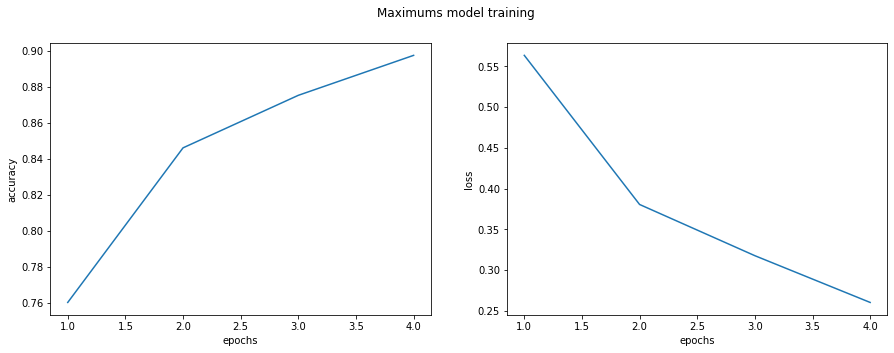

In [503]:
import matplotlib.pyplot as plt

def show_results(history, subtitle, epochs):
    metrics_data = [history.history['accuracy'], history.history['loss']]
    labels = ['accuracy', 'loss']
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    fig.suptitle(subtitle)

    for data, ax, label in zip(metrics_data, axes, labels):
        ax.set_xlabel('epochs')
        ax.set_ylabel(label)
        ax.plot(range(1,epochs), data)

    plt.show()
    
show_results(history_avg, "Averages model training", 6)
show_results(history_max, "Maximums model training", 5)

In [505]:
model_max.evaluate(maxX_test, maxy_test)

75/75 [==============================] - 93s 1s/step - loss: 0.3583 - accuracy: 0.8662


[0.3582601845264435, 0.8662499785423279]

In [504]:
model_max.save('D:/model_85_acc/max_model')

INFO:tensorflow:Assets written to: D:/model_85_acc/max_model\assets


INFO:tensorflow:Assets written to: D:/model_85_acc/max_model\assets


In [29]:
#previous model
model_avg.save('D:/arousal_models_75/avg_model')

INFO:tensorflow:Assets written to: D:/arousal_models_75/avg_model\assets


INFO:tensorflow:Assets written to: D:/arousal_models_75/avg_model\assets


In [30]:
#previous model
model_max.save('D:/arousal_models_75/max_model')

INFO:tensorflow:Assets written to: D:/arousal_models_75/max_model\assets


INFO:tensorflow:Assets written to: D:/arousal_models_75/max_model\assets


In [32]:
#previous model
model_avg.evaluate(avgX_test, avgy_test)

233/233 [==============================] - 78s 333ms/step - loss: 0.4313 - accuracy: 0.8153


[0.43130698800086975, 0.8152917623519897]

In [33]:
#previous model
model_max.evaluate(maxX_test, maxy_test)

892/892 [==============================] - 362s 405ms/step - loss: 0.2996 - accuracy: 0.8795


[0.29957151412963867, 0.8795066475868225]

In [511]:
print("Single exclamation mark in tweets with low arousal:",len(avg_df[avg_df.avg_labels == "low"][avg_df.mark == True]))
print("Single exclamation mark in tweets with medium arousal:",len(avg_df[avg_df.avg_labels == "medium"][avg_df.mark == True]))
print("Single exclamation mark in tweets with high arousal:",len(avg_df[avg_df.avg_labels == "high"][avg_df.mark == True]))

Single exclamation mark in tweets with low arousal: 1194
Single exclamation mark in tweets with medium arousal: 1354
Single exclamation mark in tweets with high arousal: 1705


<ipython-input-511-8de5c2f85876>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Single exclamation mark in tweets with low arousal:",len(avg_df[avg_df.avg_labels == "low"][avg_df.mark == True]))
<ipython-input-511-8de5c2f85876>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Single exclamation mark in tweets with medium arousal:",len(avg_df[avg_df.avg_labels == "medium"][avg_df.mark == True]))
<ipython-input-511-8de5c2f85876>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Single exclamation mark in tweets with high arousal:",len(avg_df[avg_df.avg_labels == "high"][avg_df.mark == True]))


In [512]:
print("Single word with capital letters in tweets with low arousal:",len(avg_df[avg_df.avg_labels == "low"][avg_df.caps == True]))
print("Single word with capital letters in tweets with medium arousal:",len(avg_df[avg_df.avg_labels == "medium"][avg_df.caps == True]))
print("Single word with capital letters in tweets with high arousal:",len(avg_df[avg_df.avg_labels == "high"][avg_df.caps == True]))

Single word with capital letters in tweets with low arousal: 839
Single word with capital letters in tweets with medium arousal: 1491
Single word with capital letters in tweets with high arousal: 1185


<ipython-input-512-f8b037d3f152>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Single word with capital letters in tweets with low arousal:",len(avg_df[avg_df.avg_labels == "low"][avg_df.caps == True]))
<ipython-input-512-f8b037d3f152>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Single word with capital letters in tweets with medium arousal:",len(avg_df[avg_df.avg_labels == "medium"][avg_df.caps == True]))
<ipython-input-512-f8b037d3f152>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Single word with capital letters in tweets with high arousal:",len(avg_df[avg_df.avg_labels == "high"][avg_df.caps == True]))


In [513]:
print("Single word with repeating letters in tweets with low arousal:",len(avg_df[avg_df.avg_labels == "low"][avg_df.letters == True]))
print("Single word with repeating letters in tweets with medium arousal:",len(avg_df[avg_df.avg_labels == "medium"][avg_df.letters == True]))
print("Single word with repeating letters in tweets with high arousal:",len(avg_df[avg_df.avg_labels == "high"][avg_df.letters == True]))

Single word with repeating letters in tweets with low arousal: 964
Single word with repeating letters in tweets with medium arousal: 1048
Single word with repeating letters in tweets with high arousal: 1149


<ipython-input-513-47e766b7b0dd>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Single word with repeating letters in tweets with low arousal:",len(avg_df[avg_df.avg_labels == "low"][avg_df.letters == True]))
<ipython-input-513-47e766b7b0dd>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Single word with repeating letters in tweets with medium arousal:",len(avg_df[avg_df.avg_labels == "medium"][avg_df.letters == True]))
<ipython-input-513-47e766b7b0dd>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Single word with repeating letters in tweets with high arousal:",len(avg_df[avg_df.avg_labels == "high"][avg_df.letters == True]))


In [518]:
print(len(avg_df[avg_df.avg_labels == "low"][avg_df.mark == True][avg_df.caps == True]))
print(len(avg_df[avg_df.avg_labels == "medium"][avg_df.mark == True][avg_df.caps == True]))
print(len(avg_df[avg_df.avg_labels == "high"][avg_df.mark == True][avg_df.caps == True]))

233
452
454


<ipython-input-518-5cf81d43b671>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(avg_df[avg_df.avg_labels == "low"][avg_df.mark == True][avg_df.caps == True]))
<ipython-input-518-5cf81d43b671>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(avg_df[avg_df.avg_labels == "low"][avg_df.mark == True][avg_df.caps == True]))
<ipython-input-518-5cf81d43b671>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(avg_df[avg_df.avg_labels == "medium"][avg_df.mark == True][avg_df.caps == True]))
<ipython-input-518-5cf81d43b671>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(avg_df[avg_df.avg_labels == "medium"][avg_df.mark == True][avg_df.caps == True]))
<ipython-input-518-5cf81d43b671>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(avg_df[avg_df.avg_labels == "high"][avg_df.mark == True][a

In [519]:
print(len(avg_df[avg_df.avg_labels == "low"][avg_df.mark == True][avg_df.letters == True]))
print(len(avg_df[avg_df.avg_labels == "medium"][avg_df.mark == True][avg_df.letters == True]))
print(len(avg_df[avg_df.avg_labels == "high"][avg_df.mark == True][avg_df.letters == True]))

289
386
555


<ipython-input-519-4e677c9a0eec>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(avg_df[avg_df.avg_labels == "low"][avg_df.mark == True][avg_df.letters == True]))
<ipython-input-519-4e677c9a0eec>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(avg_df[avg_df.avg_labels == "low"][avg_df.mark == True][avg_df.letters == True]))
<ipython-input-519-4e677c9a0eec>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(avg_df[avg_df.avg_labels == "medium"][avg_df.mark == True][avg_df.letters == True]))
<ipython-input-519-4e677c9a0eec>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(avg_df[avg_df.avg_labels == "medium"][avg_df.mark == True][avg_df.letters == True]))
<ipython-input-519-4e677c9a0eec>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(avg_df[avg_df.avg_labels == "high"][avg_df.mar

In [521]:
print(len(avg_df[avg_df.avg_labels == "low"][avg_df.caps == True][avg_df.letters == True]))
print(len(avg_df[avg_df.avg_labels == "medium"][avg_df.caps == True][avg_df.letters == True]))
print(len(avg_df[avg_df.avg_labels == "high"][avg_df.caps == True][avg_df.letters == True]))

170
297
297


<ipython-input-521-d1f27f4da605>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(avg_df[avg_df.avg_labels == "low"][avg_df.caps == True][avg_df.letters == True]))
<ipython-input-521-d1f27f4da605>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(avg_df[avg_df.avg_labels == "low"][avg_df.caps == True][avg_df.letters == True]))
<ipython-input-521-d1f27f4da605>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(avg_df[avg_df.avg_labels == "medium"][avg_df.caps == True][avg_df.letters == True]))
<ipython-input-521-d1f27f4da605>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(avg_df[avg_df.avg_labels == "medium"][avg_df.caps == True][avg_df.letters == True]))
<ipython-input-521-d1f27f4da605>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(avg_df[avg_df.avg_labels == "high"][avg_df.cap

In [520]:
print(len(avg_df[avg_df.avg_labels == "low"][avg_df.mark == True][avg_df.caps == True][avg_df.letters == True]))
print(len(avg_df[avg_df.avg_labels == "medium"][avg_df.mark == True][avg_df.caps == True][avg_df.letters == True]))
print(len(avg_df[avg_df.avg_labels == "high"][avg_df.mark == True][avg_df.caps == True][avg_df.letters == True]))

69
126
171


<ipython-input-520-1d5e97239911>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(avg_df[avg_df.avg_labels == "low"][avg_df.mark == True][avg_df.caps == True][avg_df.letters == True]))
<ipython-input-520-1d5e97239911>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(avg_df[avg_df.avg_labels == "low"][avg_df.mark == True][avg_df.caps == True][avg_df.letters == True]))
<ipython-input-520-1d5e97239911>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(avg_df[avg_df.avg_labels == "low"][avg_df.mark == True][avg_df.caps == True][avg_df.letters == True]))
<ipython-input-520-1d5e97239911>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(avg_df[avg_df.avg_labels == "medium"][avg_df.mark == True][avg_df.caps == True][avg_df.letters == True]))
<ipython-input-520-1d5e97239911>:2: UserWarning: Boolean Series key will be reindexed to 